# Step 0: Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

#%matplotlib inline
#%matplotlib notebook

# Step 1: Define function for settlement and face support requirements

In [2]:
def settlement(V_l, A, K, z_0, z, y):
    
    """
    V_l: Predicted volume loss [%]
    A: Cross-sectional area of tunnel [m^2]
    K: Trough width parameter [-]
    z_0: Depth to axis of the tunnel under construction [m]
    z: depth to the point under consideration [m], where z ≤ z0, in m. At the surface, z = 0 and i = Kz_0
    return: Settlement at transverse distance y from tunnel axis.
    """

    V_s = V_l*A
    i = K*(z_0 - z)
    S_max = V_s/((2*np.pi)**(0.5)*i)
    S = S_max*np.exp(-(y**2)/(2*(i**2)))

    return S


def get_T_G_Pv_Ere(D, phi_degrees, c, crit_angle_degrees, t_crown, gamma, sigma_s, hw):
    """
    Obtain forces at critical angle
    D = diameter of tunnel
    phi_degrees = Friction angle of soil
    c = cohesion
    crit_angle_degrees = critical angle in degrees
    t_crown = overburden height
    gamma = average soil unit weight in the overburden area [kN/m3]
    sigma_s = surface surcharge
    hw = distance between water table and tunnel crown
    """
    
    # Convert angles to radians
    phi = math.radians(phi_degrees)
    theta = math.radians(crit_angle_degrees)
    
    # Adjust soil unit weight in the tunnel face area [kN/m3]
    if hw < - D/2:
        gamma_face = gamma # Assume porewater pressure is negligible if no water in top half of TBM
    else:
        gamma_face = gamma - 10
            
    # Calculate self-weight of the sliding wedge, G
    G = 0.5*D**3/math.tan(theta)*gamma_face
    
    # Calculate vertical force, Pv, on the wedge
    if t_crown <= 2*D:
        sigma_z = gamma*t_crown + sigma_s
    else:
        K1 = math.tan(np.pi/4 - phi/2)**2
        A = D**2/math.tan(theta)
        U = 2*D + 2*D/math.tan(theta)
        sigma_z = (A/U*gamma - c)/(K1*math.tan(phi))*(1-np.exp(-U/A*K1*t_crown*math.tan(phi))) + sigma_s*np.exp(-U/A*K1*t_crown*math.tan(phi))
    
    if hw > 0:
        sigma_z_eff = sigma_z - hw*10
    else:
        sigma_z_eff = sigma_z
    
    Pv = D**2/math.tan(theta)*sigma_z_eff
    
    # Calculate lateral pressure coefficient to be considered in T
    K2 = (math.tan(np.pi/4 - phi/2)**2 + 1 - math.sin(phi))/2
    
    # Calculate friction force on the triangular vertical plane of the sliding wedge
    TR = K2*math.tan(phi)*((D**2*sigma_z_eff)/(2*math.tan(theta)) + (D**3*gamma_face/(6*math.tan(theta))))
    TC = c*D**2/(2*math.tan(theta))
    T = TR + TC
    
    Ere = ((G + Pv)*(math.sin(theta) - math.cos(theta)*math.tan(phi)) - 2*T - (c*D**2)/math.sin(theta))/(math.sin(theta)*math.tan(phi) + math.cos(theta))
        
    
    return T, G, Pv, Ere

def get_crit_theta(D, phi_degrees, c, t_crown, gamma, sigma_s, hw):
    """
    E_re = support force due to the earth pressure
    G = own weight of wedge
    Pv = vertical load from the soil prism
    T = Shear force on the vertical slip surface
    theta = Sliding angle
    phi = Friction angle of soil
    c = cohesion of the soil
    D = shield diameter
    """
    angles = list(np.arange(1,90, 0.01))    
    E_re = []

    for degrees in angles:
            T, G, Pv, Ere = get_T_G_Pv_Ere(D, phi_degrees, c, degrees, t_crown, gamma, sigma_s, hw)
            E_re.append(Ere)  

    return angles[E_re.index(abs(max(E_re)))]

def filter_cake_check(tau_f, d10):
    fso = 3.5*tau_f/d10

    if fso<=200:
        print("Filter cake is not formed, a penetration zone will exist. Minimum yield point of slurry must be:" + str(100*d10/3.5))
    else:
        print('Filter cake is formed, no penetration zone!')

# Step 2: Import data from drawings

Text(0, 0.5, 'mAOD [m]')

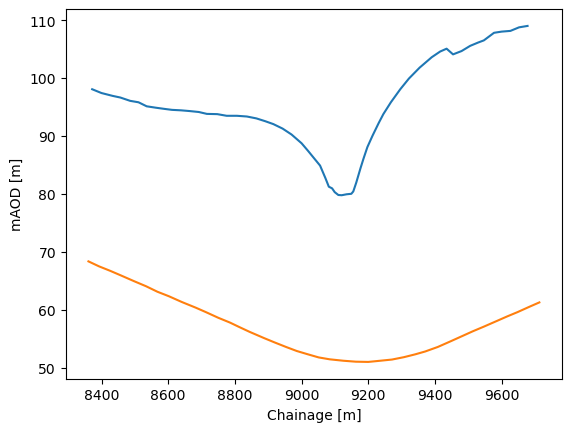

In [3]:
surface = pd.read_csv('Surface.csv')
tunnel = pd.read_csv('Tunnel.csv')

# Plot out alignment of both data
plt.plot(surface['Chainage'], surface['Elevation'])
plt.plot(tunnel['Chainage'], tunnel['Elevation'])
plt.xlabel('Chainage [m]')
plt.ylabel('mAOD [m]')

# Step 3: Data cleaning

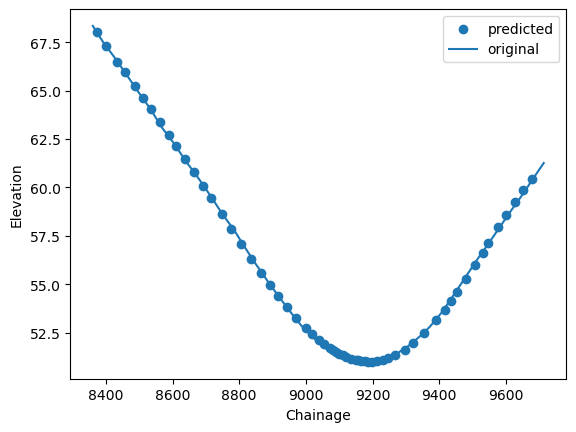

In [4]:
# Find tunnel alignment at the common chainage

fit_chainage = np.polyfit(tunnel.Chainage, tunnel.Elevation, 5)
chainage_predict = np.poly1d(fit_chainage)

# Obtain shrinkage strain at specific times for 100kN and 250kN
tunnel_elevation = chainage_predict(surface.Chainage)

# Plot to check results
plt.scatter(surface.Chainage, tunnel_elevation, label = 'predicted')
plt.plot(tunnel.Chainage, tunnel.Elevation, label = 'original')
plt.legend()
plt.xlabel('Chainage')
plt.ylabel('Elevation')

# Check if it is okay, if it is okay, then replace the original elevation data with the predicted one.
tunnel = pd.DataFrame()
tunnel['Chainage'] = surface.Chainage
tunnel['Elevation'] = tunnel_elevation

# Step 4: Plot out the surface in a 3D plot

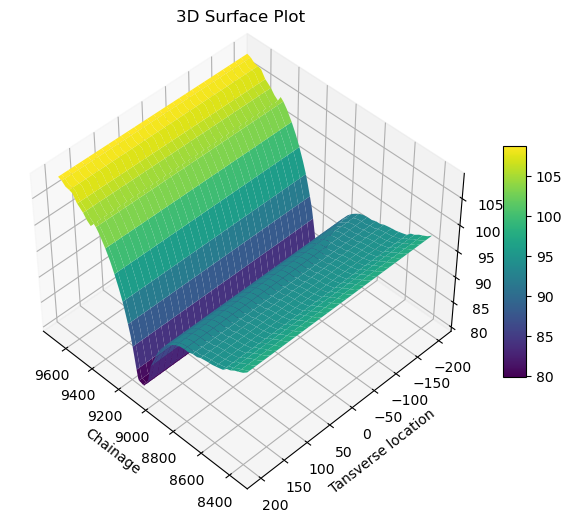

In [5]:
# Sample DataFrame
data = {'x': surface.Chainage,
        'y': np.linspace(-200, 200, 60),  # Constant along y-axis
        'z': surface.Elevation}  # Varying along x-axis
df = pd.DataFrame(data)

# Reshape Z to a 2D array
X, Z = np.meshgrid(df['x'], df['z'])

# Create a meshgrid for X and Y
Z, Y = np.meshgrid(df['z'], df['y'])

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface_graph = ax.plot_surface(X, Y, Z, cmap='viridis')

# Customize the plot (add labels, title, etc.)
ax.set_xlabel('Chainage')
ax.set_ylabel('Tansverse location')
ax.set_zlabel('Elevation')
ax.set_title('3D Surface Plot')

# Add a color bar to the plot
fig.colorbar(surface_graph, ax=ax, shrink=0.5, aspect=10)

# Plot figure
ax.view_init(45, 135) 
plt.show()

# Step 5: Calculate the settlement induced by tunnelling.

In [6]:
settlement_x = surface.Chainage
settlement_y = np.linspace(-200, 200, 60)
overburden = surface.Elevation - tunnel.Elevation
final_elevation = pd.DataFrame()

# Input for formula

V_l = 0.2
A = 100
K = 0.1
z = 0

for i in reversed(range(len(settlement_x))):
    transverse_settlement = []
    z_0 = overburden[i]
    for y in settlement_y:
        # Input for formula
        transverse_settlement.append(settlement(V_l, A, K, z_0, z, y))

    final_elevation[settlement_x[i]] = z_0 - transverse_settlement

# Plot the settled surface
    



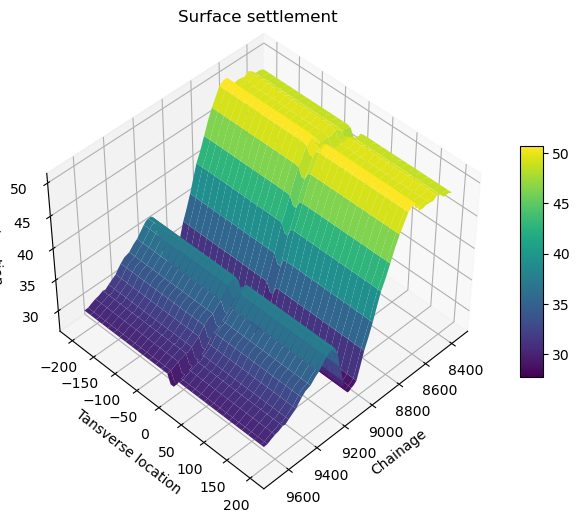

In [15]:
# Reshape Z to a 2D array
X, Y = np.meshgrid(df['x'], df['y'])

# Create a meshgrid for X and Y
Z= final_elevation

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface_graph = ax.plot_surface(X, Y, Z, cmap='viridis')

# Customize the plot (add labels, title, etc.)
ax.set_xlabel('Chainage')
ax.set_ylabel('Tansverse location')
ax.set_zlabel('Elevation')
ax.set_title('Surface settlement')

# Add a color bar to the plot
fig.colorbar(surface_graph, ax=ax, shrink=0.5, aspect=10)

# Plot figure
ax.view_init(45, 45) 
plt.show()

# Step 5: Check if filter cake or penetration zone is formed at the TBM face.

In [8]:
# Check to ensure that a filter cake is formed 

# Input
tau_f = 40 # yield point of slurry
d10 = 0.001 # characteristic grain size of the soil

# Output
filter_cake_check(tau_f, d10)

Filter cake is formed, no penetration zone!


# Step 6: Force exerted on the TBM face

In [9]:
# Ground parameters
phi_degrees = 30 # Friction angle of soil [degrees]
c = 0 # Cohesion [kN/m2]
t_crown = 15 # Distance between surface and tunnel crown [m]
gamma = 18 # Unit weight of soil [kN/m3]
sigma_s = 10 # Overburden pressure [kN/m2]
hw = 13 # Height between water table and tunnel crown [m]

# Machine parameters
D = 10 # Tunnel shield diameter
gamma_s = 12 # unit weight of slurry/support medium [kN/m^3]
delta = 10 # Support pressure deviations (+/-)

# Maximization of support force due to the earth pressure using the variation of sliding angle.
crit_angle_degrees = get_crit_theta(D, phi_degrees, c, t_crown, gamma, sigma_s, hw)

# Determination of forces
T, G, Pv, Ere = get_T_G_Pv_Ere(D, phi_degrees, c, crit_angle_degrees, t_crown, gamma, sigma_s, hw)

print('Critical sliding angle is: ' + str(crit_angle_degrees) + ' degrees, maximal required support force due to earth pressure is: ' + str(Ere)+' kN')

Critical sliding angle is: 66.56000000000006 degrees, maximal required support force due to earth pressure is: 4122.319605418542 kN


In [10]:
# Recalculation of the force determined from rectangular-shaped front plane of the wedge to the real circular tunnel face:
Ecir = Ere*np.pi*D**2/4/D**2

# Acting water pressure force on the rectangular tunnel face, and convert to circular face
Wre = 10*(hw + D/2)*D**2
Wcir = Wre*np.pi*D**2/4/D**2

# Total support force to counter earth pressure, considering safety factors
earth_force_FOS = 1.5
water_force_FOS = 1.05
face_force = Ecir*earth_force_FOS + Wcir*water_force_FOS

print ('The maximum face pressure is: ' + str(face_force))

The maximum face pressure is: 19700.518658761303


# Step 7: Determination of pressures and checks

In [11]:
# Check for minimum pressure required at the crown
min_pressure_crown = 4*face_force/(np.pi*D**2) - gamma_s*D/2

# The support pressure min_pressure_crown must be 1.05 times higher than groundwater pressure in the tunnel crown
if 1.05*10*hw < min_pressure_crown :
    print('Support pressure is safe for medium lowering and compressed air intervention')
else:
    print('A higher pressure is needed at the crown.')
    
# Support pressure at the tunnel crown for regular advance with consideration of support pressure deviations +/- 10 kN/m2
min_pressure_crown_limit = min_pressure_crown + delta

# Total stress at tunnel crown considering the minimal unit weight of the soil
min_sigmav_crown = (gamma-1)*t_crown

# Maximal allowable support pressure at tunnel crown due to break-up safety
max_pressure_crown = 0.9*min_sigmav_crown

# Highest support pressure due to face pressure deviations
max_pressure_crown_limit = max_pressure_crown - delta

if max_pressure_crown_limit>min_pressure_crown_limit:
    print('Excavation is possible')
else:
    print('Excavation is not possible')


Support pressure is safe for medium lowering and compressed air intervention
Excavation is possible


# Step 8: Apply Step 6 & 7 model to the project data

In [12]:
# Data manipulation
t_crown_all = surface.Elevation - tunnel.Elevation - 9 # Distance between surface and tunnel crown [m]
hw_all = 80 - tunnel.Elevation - 9 # Height between water table and tunnel crown [m]

# Ground parameters
phi_degrees = 30 # Friction angle of soil [degrees]
c = 0 # Cohesion [kN/m2]
gamma = 16 # Unit weight of soil [kN/m3]
sigma_s = 0 # Overburden pressure [kN/m2]

# Machine parameters
D = 14 # Tunnel shield diameter
gamma_s = 12 # unit weight of slurry/support medium [kN/m^3]
delta = 10 # Support pressure deviations (+/-)

# Factor of safety
earth_force_FOS = 1.5
water_force_FOS = 1.05

In [13]:
# Obtain support pressure to all sections
max_pressure_crown_limit_all = []
max_pressure_crown_all = []
min_pressure_crown_all = []
min_pressure_crown_limit_all = []

for i in range(len(t_crown_all)):
    t_crown = t_crown_all[i]
    hw = hw_all[i]
    
    # Maximization of support force due to the earth pressure using the variation of sliding angle.
    crit_angle_degrees = get_crit_theta(D, phi_degrees, c, t_crown, gamma, sigma_s, hw)

    # Determination of forces
    T, G, Pv, Ere = get_T_G_Pv_Ere(D, phi_degrees, c, crit_angle_degrees, t_crown, gamma, sigma_s, hw)

    # Recalculation of the force determined from rectangular-shaped front plane of the wedge to the real circular tunnel face:
    Ecir = Ere*np.pi*D**2/4/D**2

    # Acting water pressure force on the rectangular tunnel face, and convert to circular face
    Wre = 10*(hw + D/2)*D**2
    Wcir = Wre*np.pi*D**2/4/D**2

    # Total support force to counter earth pressure, considering safety factors
    face_force = Ecir*earth_force_FOS + Wcir*water_force_FOS
    
    min_pressure_crown = 4*face_force/(np.pi*D**2) - gamma_s*D/2

    # The support pressure min_pressure_crown must be 1.05 times higher than groundwater pressure in the tunnel crown
    if 1.05*10*hw < min_pressure_crown :
        print('Support pressure is safe for medium lowering and compressed air intervention')
    else:
        print('A higher pressure is needed at the crown.')

    # Support pressure at the tunnel crown for regular advance with consideration of support pressure deviations +/- 10 kN/m2
    min_pressure_crown_limit = min_pressure_crown + delta

    # Total stress at tunnel crown considering the minimal unit weight of the soil
    min_sigmav_crown = (gamma-1)*t_crown

    # Maximal allowable support pressure at tunnel crown due to break-up safety
    max_pressure_crown = 0.9*min_sigmav_crown

    # Highest support pressure due to face pressure deviations
    max_pressure_crown_limit = max_pressure_crown - delta

    if max_pressure_crown_limit>min_pressure_crown_limit:
        print('Excavation is possible')
    else:
        print('Excavation is not possible')
    
    # Append values to list
    max_pressure_crown_limit_all.append(max_pressure_crown_limit)
    max_pressure_crown_all.append(max_pressure_crown)
    min_pressure_crown_all.append(min_pressure_crown)
    min_pressure_crown_limit_all.append(min_pressure_crown_limit)

Support pressure is safe for medium lowering and compressed air intervention
Excavation is possible
Support pressure is safe for medium lowering and compressed air intervention
Excavation is possible
Support pressure is safe for medium lowering and compressed air intervention
Excavation is possible
Support pressure is safe for medium lowering and compressed air intervention
Excavation is possible
Support pressure is safe for medium lowering and compressed air intervention
Excavation is possible
Support pressure is safe for medium lowering and compressed air intervention
Excavation is possible
Support pressure is safe for medium lowering and compressed air intervention
Excavation is possible
Support pressure is safe for medium lowering and compressed air intervention
Excavation is possible
Support pressure is safe for medium lowering and compressed air intervention
Excavation is possible
Support pressure is safe for medium lowering and compressed air intervention
Excavation is possible


Text(0.5, 0, 'Chainage [m]')

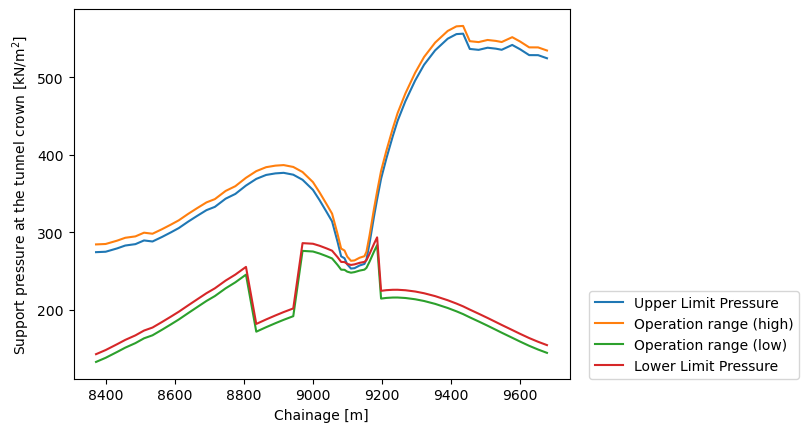

In [14]:
# Plot of the support pressure requirements
plt.plot(tunnel['Chainage'], max_pressure_crown_limit_all, label = "Upper Limit Pressure")
plt.plot(tunnel['Chainage'], max_pressure_crown_all, label = "Operation range (high)")
plt.plot(tunnel['Chainage'], min_pressure_crown_all, label = "Operation range (low)")
plt.plot(tunnel['Chainage'], min_pressure_crown_limit_all, label = "Lower Limit Pressure")
plt.ylabel('Support pressure at the tunnel crown [kN/m$^2$]')
plt.legend(loc=(1.04, 0))
plt.xlabel('Chainage [m]')

Operation range (high) represents the maximum pressure before a TBM blowout occurs.

Operation range(low) represents the minimum pressure before face becomes unstable.

The stress can be found considering the full weight of the overburden or accounting for a soil arch above the wedge according to Janssen’s silo theory that leads to a decrease in vertical stress. The criterion used to select between the two approaches is defined by the overburden
height. If the overburden height is lower than twice the tunnel diameter, the full weight of the overburden is applied. Janssen´s silo theory may be adopted if the overburden is higher. However,
Anagnostou & Kovári (1994) suggest always using the Janssen´s equation. The coefficients of the lateral
earth pressure at the lateral planes of the silo vary significantly among different authors (Tab. 3). The
authors of this recommendation suggest to use the coefficient according to Melix (1987) based on extensive practical experience.